## Library Imports

In [2]:
import numpy as np
import pandas as pd
import requests
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import percentileofscore as sc
import json
from statistics import mean
from my_key import API_KEY
import xlsxwriter
import warnings
import datetime
import bs4 as bs
import requests
from io import StringIO
import pandas_ta as ta
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, LSTM, Activation, Dropout, Dense

#warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)

# Collecting data required for the research algorithms

## Importing List of Stocks


In [2]:
wiki_data=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies') # Open the link and download S&P company details in a table
data = wiki_data[0] # All data is stored in first cell
sorted_data = data.sort_values(by=['Symbol'], ascending=True) # Sort the dataframe on ticker in alphabetical ascending order

### Run "writer" cells to download a .xlsx file containing the tickers currently present in the S&P 500 index. It will be created in the same folder where this python code file is located.

In [4]:
writer = pd.ExcelWriter('Tickers.xlsx', engine='xlsxwriter')
sorted_data.to_excel(writer, sheet_name='Tickers', index = False)

In [5]:
writer.save()

In [3]:
sorted_data

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
12,A,Agilent Technologies,Health Care,Health Care Equipment,"Santa Clara, California",2000-06-05,1090872,1999
29,AAL,American Airlines Group,Industrials,Passenger Airlines,"Fort Worth, Texas",2015-03-23,6201,1934
9,AAP,Advance Auto Parts,Consumer Discretionary,Automotive Retail,"Raleigh, North Carolina",2015-07-09,1158449,1932
44,AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals","Cupertino, California",1982-11-30,320193,1977
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
...,...,...,...,...,...,...,...,...
498,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
500,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
499,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
501,ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


In [6]:
stocks_str = ','.join(sorted_data['Symbol'].tolist())
stocks_str

'A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL,ALLE,AMAT,AMCR,AMD,AME,AMGN,AMP,AMT,AMZN,ANET,ANSS,AON,AOS,APA,APD,APH,APTV,ARE,ATO,ATVI,AVB,AVGO,AVY,AWK,AXON,AXP,AZO,BA,BAC,BALL,BAX,BBWI,BBY,BDX,BEN,BF.B,BG,BIIB,BIO,BK,BKNG,BKR,BLK,BMY,BR,BRK.B,BRO,BSX,BWA,BXP,C,CAG,CAH,CARR,CAT,CB,CBOE,CBRE,CCI,CCL,CDAY,CDNS,CDW,CE,CEG,CF,CFG,CHD,CHRW,CHTR,CI,CINF,CL,CLX,CMA,CMCSA,CME,CMG,CMI,CMS,CNC,CNP,COF,COO,COP,COST,CPB,CPRT,CPT,CRL,CRM,CSCO,CSGP,CSX,CTAS,CTLT,CTRA,CTSH,CTVA,CVS,CVX,CZR,D,DAL,DD,DE,DFS,DG,DGX,DHI,DHR,DIS,DLR,DLTR,DOV,DOW,DPZ,DRI,DTE,DUK,DVA,DVN,DXC,DXCM,EA,EBAY,ECL,ED,EFX,EG,EIX,EL,ELV,EMN,EMR,ENPH,EOG,EPAM,EQIX,EQR,EQT,ES,ESS,ETN,ETR,ETSY,EVRG,EW,EXC,EXPD,EXPE,EXR,F,FANG,FAST,FCX,FDS,FDX,FE,FFIV,FI,FICO,FIS,FITB,FLT,FMC,FOX,FOXA,FRT,FSLR,FTNT,FTV,GD,GE,GEHC,GEN,GILD,GIS,GL,GLW,GM,GNRC,GOOG,GOOGL,GPC,GPN,GRMN,GS,GWW,HAL,HAS,HBAN,HCA,HD,HES,HIG,HII,HLT,HOLX,HON,HPE,HPQ,HRL,HSIC,HST,HSY,HUM,HWM,IBM,ICE,IDXX,IEX,IFF,ILMN

## Momentum data API call

In [7]:
stats_data_url = f'https://financialmodelingprep.com/api/v3/stock-price-change/{stocks_str}?apikey={API_KEY}'
stats_data = requests.get(stats_data_url).json()

### List is Sorted alphabetically and mapped into a pandas dataframe

In [8]:
sorted_stats = sorted(stats_data, key=lambda a: (a['symbol']))

In [9]:
sorted_stats

[{'symbol': 'A',
  '1D': 0.319,
  '5D': -0.56577086,
  '1M': -6.42812,
  '3M': -1.22324,
  '6M': -15.36119,
  'ytd': -20.34791,
  '1Y': -10.59325,
  '3Y': 22.44877,
  '5Y': 81.13065,
  '10Y': 250.98385,
  'max': 279.7585},
 {'symbol': 'AAL',
  '1D': -1.4208,
  '5D': -1.7532,
  '1M': -13.68483,
  '3M': 5.57971,
  '6M': -6.36247,
  'ytd': 14.36421,
  '1Y': 4.14582,
  '3Y': 8.40774,
  '5Y': -62.4678,
  '10Y': -10.11721,
  'max': -24.50777},
 {'symbol': 'AAP',
  '1D': -2.1601,
  '5D': -1.53623,
  '1M': -6.62452,
  '3M': -41.03966,
  '6M': -51.0695,
  'ytd': -55.16695,
  '1Y': -62.23667,
  '3Y': -56.76467,
  '5Y': -58.66391,
  '10Y': -18.24308,
  'max': 389.48127},
 {'symbol': 'AAPL',
  '1D': -2.617,
  '5D': 2.36796,
  '1M': -8.49287,
  '3M': 2.64199,
  '6M': 20.22357,
  'ytd': 41.02503,
  '1Y': 5.28264,
  '3Y': 40.13984,
  '5Y': 226.38786,
  '10Y': 882.07127,
  'max': 137321.11414},
 {'symbol': 'ABBV',
  '1D': -0.3467,
  '5D': -2.47521,
  '1M': 2.36765,
  '3M': 3.83989,
  '6M': -4.02069,
 

In [10]:
stats_df = pd.DataFrame.from_records(sorted_stats)
stats_df

,symbol,1D,5D,1M,3M,6M,ytd,1Y,3Y,5Y,10Y,max
0,A,0.3190,-0.565771,-6.42812,-1.22324,-15.36119,-20.34791,-10.59325,22.44877,81.13065,250.98385,279.75850
1,AAL,-1.4208,-1.753200,-13.68483,5.57971,-6.36247,14.36421,4.14582,8.40774,-62.46780,-10.11721,-24.50777
2,AAP,-2.1601,-1.536230,-6.62452,-41.03966,-51.06950,-55.16695,-62.23667,-56.76467,-58.66391,-18.24308,389.48127
3,AAPL,-2.6170,2.367960,-8.49287,2.64199,20.22357,41.02503,5.28264,40.13984,226.38786,882.07127,137321.11414
4,ABBV,-0.3467,-2.475210,2.36765,3.83989,-4.02069,-9.73642,6.27946,55.08412,50.48255,237.33026,317.34055
...,...,...,...,...,...,...,...,...,...,...,...,...
496,YUM,0.1159,0.177853,-6.08235,-1.00863,2.14460,2.04001,12.97637,34.16529,53.96957,79.85562,2374.90564
497,ZBH,-0.4571,-4.001180,-18.84361,-11.11413,-6.82559,-10.17835,4.21604,-13.93134,-6.09856,46.34537,295.72516
498,ZBRA,-1.5439,1.565960,-12.11871,1.73304,-8.90655,2.19831,-16.72825,-3.43876,57.43295,462.55553,6456.93079
499,ZION,1.4420,0.524641,-6.96356,18.98516,-31.43028,-28.86917,-38.75267,4.32809,-35.47361,18.00753,1783.60656


In [11]:
price_data_url = f'https://financialmodelingprep.com/api/v3/quote-short/{stocks_str}?apikey={API_KEY}'
price_data = requests.get(price_data_url).json()

In [12]:
price_data

[{'symbol': 'A', 'price': 119.51, 'volume': 1656964},
 {'symbol': 'AAL', 'price': 14.57, 'volume': 23163318},
 {'symbol': 'AAP', 'price': 67.94, 'volume': 3335206},
 {'symbol': 'AAPL', 'price': 176.38, 'volume': 51899947},
 {'symbol': 'ABBV', 'price': 146.57, 'volume': 2702471},
 {'symbol': 'ABC', 'price': 178.77, 'volume': 972388},
 {'symbol': 'ABT', 'price': 103.73, 'volume': 2458618},
 {'symbol': 'ACGL', 'price': 75.41, 'volume': 1175536},
 {'symbol': 'ACN', 'price': 314.05, 'volume': 1679145},
 {'symbol': 'ADBE', 'price': 512.43, 'volume': 2873514},
 {'symbol': 'ADI', 'price': 173.69, 'volume': 6695137},
 {'symbol': 'ADM', 'price': 80.31, 'volume': 1629370},
 {'symbol': 'ADP', 'price': 249.795, 'volume': 1070517},
 {'symbol': 'ADSK', 'price': 208.6, 'volume': 2586472},
 {'symbol': 'AEE', 'price': 80, 'volume': 774447},
 {'symbol': 'AEP', 'price': 78.83, 'volume': 2566394},
 {'symbol': 'AES', 'price': 17.72, 'volume': 4361698},
 {'symbol': 'AFL', 'price': 74.32, 'volume': 1636116},


In [13]:
sorted_price = sorted(price_data, key=lambda a: (a['symbol']))

In [14]:
price_df = pd.DataFrame.from_records(sorted_price)
price_df

,symbol,price,volume
0,A,119.510,1656964
1,AAL,14.570,23163318
2,AAP,67.940,3335206
3,AAPL,176.380,51899947
4,ABBV,146.570,2702471
...,...,...,...
496,YUM,129.550,850203
497,ZBH,114.325,1649843
498,ZBRA,265.920,242782
499,ZION,34.470,2513898


# Merging dataframes. 

In [15]:
temp_df = pd.merge(stats_df, price_df, on='symbol', how='left')

In [16]:
temp_df.drop_duplicates(subset=['symbol'], keep='first', inplace=True, ignore_index=True)

In [17]:
temp_df

,symbol,1D,5D,1M,3M,6M,ytd,1Y,3Y,5Y,10Y,max,price,volume
0,A,0.3190,-0.565771,-6.42812,-1.22324,-15.36119,-20.34791,-10.59325,22.44877,81.13065,250.98385,279.75850,119.510,1656964
1,AAL,-1.4208,-1.753200,-13.68483,5.57971,-6.36247,14.36421,4.14582,8.40774,-62.46780,-10.11721,-24.50777,14.570,23163318
2,AAP,-2.1601,-1.536230,-6.62452,-41.03966,-51.06950,-55.16695,-62.23667,-56.76467,-58.66391,-18.24308,389.48127,67.940,3335206
3,AAPL,-2.6170,2.367960,-8.49287,2.64199,20.22357,41.02503,5.28264,40.13984,226.38786,882.07127,137321.11414,176.380,51899947
4,ABBV,-0.3467,-2.475210,2.36765,3.83989,-4.02069,-9.73642,6.27946,55.08412,50.48255,237.33026,317.34055,146.570,2702471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,YUM,0.1159,0.177853,-6.08235,-1.00863,2.14460,2.04001,12.97637,34.16529,53.96957,79.85562,2374.90564,129.550,850203
497,ZBH,-0.4571,-4.001180,-18.84361,-11.11413,-6.82559,-10.17835,4.21604,-13.93134,-6.09856,46.34537,295.72516,114.325,1649843
498,ZBRA,-1.5439,1.565960,-12.11871,1.73304,-8.90655,2.19831,-16.72825,-3.43876,57.43295,462.55553,6456.93079,265.920,242782
499,ZION,1.4420,0.524641,-6.96356,18.98516,-31.43028,-28.86917,-38.75267,4.32809,-35.47361,18.00753,1783.60656,34.470,2513898


# Short-Term Momentum Research Algorithm

In [18]:
s_m_cols = ['symbol', 'price', '1D','1D-Percentile', '5D', '5D-Percentile', '1M',
            '1M-Percentile', 'momScore',]
s_m_df = pd.DataFrame(columns = s_m_cols)
for index, row in temp_df.iterrows():
    #try: 
    s_m_df = s_m_df.append(        
    pd.Series(
    [
        temp_df.loc[index,'symbol'],
        temp_df.loc[index,'price'],
        temp_df.loc[index,'1D'],
        'NA',
        temp_df.loc[index,'5D'],
        'NA',
        temp_df.loc[index,'1M'],
        'NA',
        'NA'
    ],
    index = s_m_cols),
        ignore_index = True
    )
    #except:
    #    print("An exception occurred")
s_m_df

,symbol,price,1D,1D-Percentile,5D,5D-Percentile,1M,1M-Percentile,momScore
0,A,119.510,0.3190,NA,-0.565771,NA,-6.42812,NA,NA
1,AAL,14.570,-1.4208,NA,-1.753200,NA,-13.68483,NA,NA
2,AAP,67.940,-2.1601,NA,-1.536230,NA,-6.62452,NA,NA
3,AAPL,176.380,-2.6170,NA,2.367960,NA,-8.49287,NA,NA
4,ABBV,146.570,-0.3467,NA,-2.475210,NA,2.36765,NA,NA
...,...,...,...,...,...,...,...,...,...
496,YUM,129.550,0.1159,NA,0.177853,NA,-6.08235,NA,NA
497,ZBH,114.325,-0.4571,NA,-4.001180,NA,-18.84361,NA,NA
498,ZBRA,265.920,-1.5439,NA,1.565960,NA,-12.11871,NA,NA
499,ZION,34.470,1.4420,NA,0.524641,NA,-6.96356,NA,NA


### Select Intervals, Calculate Percentiles, Add Weights to Percentiles and Calculate Score for each Relevant Ticker

In [19]:
intervals = [
    '1D',
    '5D',
    '1M',
    ]

s_m_df.dropna(inplace=True)
for row in s_m_df.index:
    for interval in intervals:
        change_col = f'{interval}'
        percentile_col = f'{interval}-Percentile'
        s_m_df.loc[row, percentile_col] = stats.percentileofscore(s_m_df[change_col],
                                                                    s_m_df.loc[row, change_col])/100

In [20]:
weights = [0.6, 1.5, 0.9]
for row in s_m_df.index:
    i = 0
    momentum_percentiles = []
    for interval in intervals:
        percentile_col = f'{interval}-Percentile'
        s_m_df.loc[row, percentile_col] = float(s_m_df.loc[row, percentile_col])*weights[i]
        momentum_percentiles.append(s_m_df.loc[row, f'{interval}-Percentile'])
        i = i+1
    s_m_df.loc[row, 'momScore'] = mean(momentum_percentiles)

In [21]:
s_momentum_df = s_m_df.copy()
s_momentum_df.sort_values('momScore', ascending = False, inplace = True)
s_momentum_df.reset_index(inplace = True, drop = True)

In [22]:
s_momentum_df

,symbol,price,1D,1D-Percentile,5D,5D-Percentile,1M,1M-Percentile,momScore
0,DLR,127.46,1.3437,0.591617,5.79349,1.48503,3.525020,0.808383,0.961677
1,NVDA,471.63,0.0998,0.505389,10.62038,1.497006,5.718190,0.856886,0.953094
2,ADSK,208.60,2.0748,0.596407,6.15776,1.488024,-0.916734,0.675449,0.91996
3,ETN,220.93,-0.1672,0.453892,3.84977,1.428144,6.544170,0.865868,0.915968
4,FDS,440.46,0.6651,0.567665,2.93767,1.39521,0.851765,0.731138,0.898004
...,...,...,...,...,...,...,...,...,...
496,ILMN,159.60,-2.6473,0.052695,-4.83573,0.02994,-15.137980,0.055689,0.046108
497,WBA,25.32,-4.5968,0.010778,-5.06187,0.023952,-17.362920,0.041317,0.025349
498,DXCM,100.98,-3.2573,0.038323,-5.98641,0.008982,-20.936420,0.02515,0.024152
499,DLTR,123.88,-12.8955,0.001198,-12.76056,0.002994,-17.851460,0.037725,0.013972


### Run "writer" cells to download a .xlsx file containing the algorithm output. It will be created in the same folder where this python code file is located.

In [28]:
writer = pd.ExcelWriter('STMOut.xlsx', engine='xlsxwriter')
s_momentum_df.to_excel(writer, sheet_name='STMOut', index = False)

In [29]:
writer.save()

# Long-term Momentum Research Algorithm

In [31]:
l_m_cols = ['symbol', 'price', '1Y','1Y-Percentile', '3Y', '3Y-Percentile', '5Y',
            '5Y-Percentile', 'momScore',]
l_m_df = pd.DataFrame(columns = l_m_cols)
for index, row in temp_df.iterrows():
    #try: 
    l_m_df = l_m_df.append(        
    pd.Series(
    [
        temp_df.loc[index,'symbol'],
        temp_df.loc[index,'price'],
        temp_df.loc[index,'1Y'],
        'NA',
        temp_df.loc[index,'3Y'],
        'NA',
        temp_df.loc[index,'5Y'],
        'NA',
        'NA'
    ],
    index = l_m_cols),
        ignore_index = True
    )
    #except:
    #    print("An exception occurred")
l_m_df

,symbol,price,1Y,1Y-Percentile,3Y,3Y-Percentile,5Y,5Y-Percentile,momScore
0,A,119.510,-10.59325,NA,22.44877,NA,81.13065,NA,NA
1,AAL,14.570,4.14582,NA,8.40774,NA,-62.46780,NA,NA
2,AAP,67.940,-62.23667,NA,-56.76467,NA,-58.66391,NA,NA
3,AAPL,176.380,5.28264,NA,40.13984,NA,226.38786,NA,NA
4,ABBV,146.570,6.27946,NA,55.08412,NA,50.48255,NA,NA
...,...,...,...,...,...,...,...,...,...
496,YUM,129.550,12.97637,NA,34.16529,NA,53.96957,NA,NA
497,ZBH,114.325,4.21604,NA,-13.93134,NA,-6.09856,NA,NA
498,ZBRA,265.920,-16.72825,NA,-3.43876,NA,57.43295,NA,NA
499,ZION,34.470,-38.75267,NA,4.32809,NA,-35.47361,NA,NA


### Select Intervals, Calculate Percentiles, Add Weights to Percentiles and Calculate Score for each Relevant Ticker

In [32]:
intervals = [
    '1Y',
    '3Y',
    '5Y',
    ]

l_m_df.dropna(inplace=True)
for row in l_m_df.index:
    for interval in intervals:
        change_col = f'{interval}'
        percentile_col = f'{interval}-Percentile'
        l_m_df.loc[row, percentile_col] = stats.percentileofscore(l_m_df[change_col],
                                                                    l_m_df.loc[row, change_col])/100

In [33]:
weights = [0.85, 1.25, 0.95]
for row in l_m_df.index:
    i = 0
    momentum_percentiles = []
    for interval in intervals:
        percentile_col = f'{interval}-Percentile'
        l_m_df.loc[row, percentile_col] = float(l_m_df.loc[row, percentile_col])*weights[i]
        momentum_percentiles.append(l_m_df.loc[row, f'{interval}-Percentile'])
        i = i+1
    l_m_df.loc[row, 'momScore'] = mean(momentum_percentiles)

In [34]:
l_momentum_df = l_m_df.copy()
l_momentum_df.sort_values('momScore', ascending = False, inplace = True)
l_momentum_df.reset_index(inplace = True, drop = True)

In [35]:
l_momentum_df

,symbol,price,1Y,1Y-Percentile,3Y,3Y-Percentile,5Y,5Y-Percentile,momScore
0,NVDA,471.63,173.85321,0.85,270.77101,1.23004,593.01300,0.946208,1.008749
1,LLY,547.94,71.83805,0.838124,266.46602,1.227545,418.04860,0.940519,1.002063
2,PWR,201.55,38.89463,0.800798,295.97250,1.237525,496.83151,0.942415,0.99358
3,AVGO,854.46,60.96376,0.834731,155.82635,1.192615,308.83254,0.923453,0.983599
4,ON,89.96,24.89241,0.739721,320.66869,1.24002,325.94697,0.931038,0.970259
...,...,...,...,...,...,...,...,...,...
496,IFF,65.40,-44.12644,0.016966,-46.78167,0.02495,-50.34546,0.032236,0.024717
497,FIS,55.26,-41.84994,0.027146,-60.99386,0.007485,-49.24222,0.037924,0.024185
498,PARA,14.73,-41.10356,0.030539,-46.70767,0.027445,-72.25989,0.007585,0.021856
499,AAP,67.94,-62.23667,0.001697,-56.76467,0.012475,-58.66391,0.020858,0.011677


# LSTM Implementation

## Using FMP API retrieve OHLC Data.

In [8]:
from fmp_python.fmp import FMP
fmp = FMP(api_key=API_KEY)
data_raw = fmp.get_historical_price('NVDA')

In [9]:
data_df =  pd.DataFrame (data_raw, columns = ['date', 'open', 'high', 'low', 'close', 'adjClose', 'volume'])

In [10]:
data_df

,date,open,high,low,close,adjClose,volume
0,2023-08-25,470.1200,478.0500,450.2400,460.1800,460.180000,92319504
1,2023-08-24,502.1600,502.6600,471.5900,471.6300,471.630000,115588734
2,2023-08-23,458.6600,472.0000,452.0800,471.1600,471.160000,77856508
3,2023-08-22,481.3500,481.8700,453.3310,456.6800,456.680000,75595821
4,2023-08-21,444.9400,470.6500,442.2200,469.6700,469.670000,69255837
...,...,...,...,...,...,...,...
1252,2018-09-04,70.0375,71.3050,69.7500,70.9250,70.315720,39168908
1253,2018-08-31,69.2500,70.3000,69.1500,70.1700,69.567215,30659000
1254,2018-08-30,69.3075,70.4293,69.0800,69.4525,68.855865,34660920
1255,2018-08-29,68.4800,69.8750,68.2700,69.6225,69.024422,42010964


### Run "writer" cells to download a .xlsx file containing the OHLC data. It will be created in the same folder where this python code file is located.

In [11]:
writer = pd.ExcelWriter('NVDA-OHLCV.xlsx', engine='xlsxwriter')
data_df.to_excel(writer, sheet_name='NVDA-OHLCV', index = False)

In [12]:
writer.save()

C:\Users\44797\AppData\Local\Temp\ipykernel_5884\934276808.py:1: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


### Invert the list to begin with the oldest entry.

In [13]:
hist_price_ = data_df.iloc[::-1]
hist_price_.reset_index(inplace = True, drop = True)

### Add technical indicators that could help LSTM predict more accurately.

In [14]:
hist_price_['RSI4'] = ta.rsi(hist_price_.close, length = 4)
hist_price_['RSI7'] = ta.rsi(hist_price_.close, length = 7)
hist_price_['RSI10'] = ta.rsi(hist_price_.close, length = 10)
hist_price_['RSI15'] = ta.rsi(hist_price_.close, length = 15)
hist_price_['EMA10'] = ta.ema(hist_price_.close, length = 10)
hist_price_['EMA15'] = ta.ema(hist_price_.close, length = 15)

C:\Users\44797\AppData\Local\Temp\ipykernel_5884\4083113107.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_price_['RSI4'] = ta.rsi(hist_price_.close, length = 4)
C:\Users\44797\AppData\Local\Temp\ipykernel_5884\4083113107.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_price_['RSI7'] = ta.rsi(hist_price_.close, length = 7)
C:\Users\44797\AppData\Local\Temp\ipykernel_5884\4083113107.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

### Clean the data by removing rows with N/A values

In [15]:
hist_price_.dropna(inplace = True)
hist_price_.reset_index(inplace = True, drop = True)
hist_price_

C:\Users\44797\AppData\Local\Temp\ipykernel_5884\2134127475.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_price_.dropna(inplace = True)


,date,open,high,low,close,adjClose,volume,RSI4,RSI7,RSI10,RSI15,EMA10,EMA15
0,2018-09-19,67.5681,68.1748,67.0625,67.9950,67.410896,22485860,44.938544,45.106414,45.424132,45.870546,68.396793,68.677646
1,2018-09-20,66.7625,67.1900,66.0250,66.5700,65.998116,43058276,26.200869,33.149607,35.870778,37.980060,68.064649,68.414190
2,2018-09-21,66.6900,67.1500,65.5275,65.8625,65.296715,43512628,20.533209,28.737163,32.141656,34.796048,67.664258,68.095229
3,2018-09-24,65.5500,66.4600,64.6700,66.4250,65.854378,29391304,35.356588,36.568704,37.849402,39.142103,67.438939,67.886450
4,2018-09-25,67.0925,67.3550,66.2275,67.1025,66.526054,28038984,50.257548,45.053777,44.137588,43.962165,67.377768,67.788456
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237,2023-08-21,444.9400,470.6500,442.2200,469.6700,469.670000,69255837,82.799168,70.322109,64.755256,61.308491,441.810563,441.827189
1238,2023-08-22,481.3500,481.8700,453.3310,456.6800,456.680000,75595821,62.761582,59.137171,56.946528,55.988693,444.514097,443.683790
1239,2023-08-23,458.6600,472.0000,452.0800,471.1600,471.160000,77856508,72.612388,66.140819,62.541216,60.121421,449.358807,447.118316
1240,2023-08-24,502.1600,502.6600,471.5900,471.6300,471.630000,115588734,72.922386,66.359162,62.715950,60.251225,453.408115,450.182277


### Visualize the data using matplotlib library

Text(0, 0.5, 'Prices ($)')

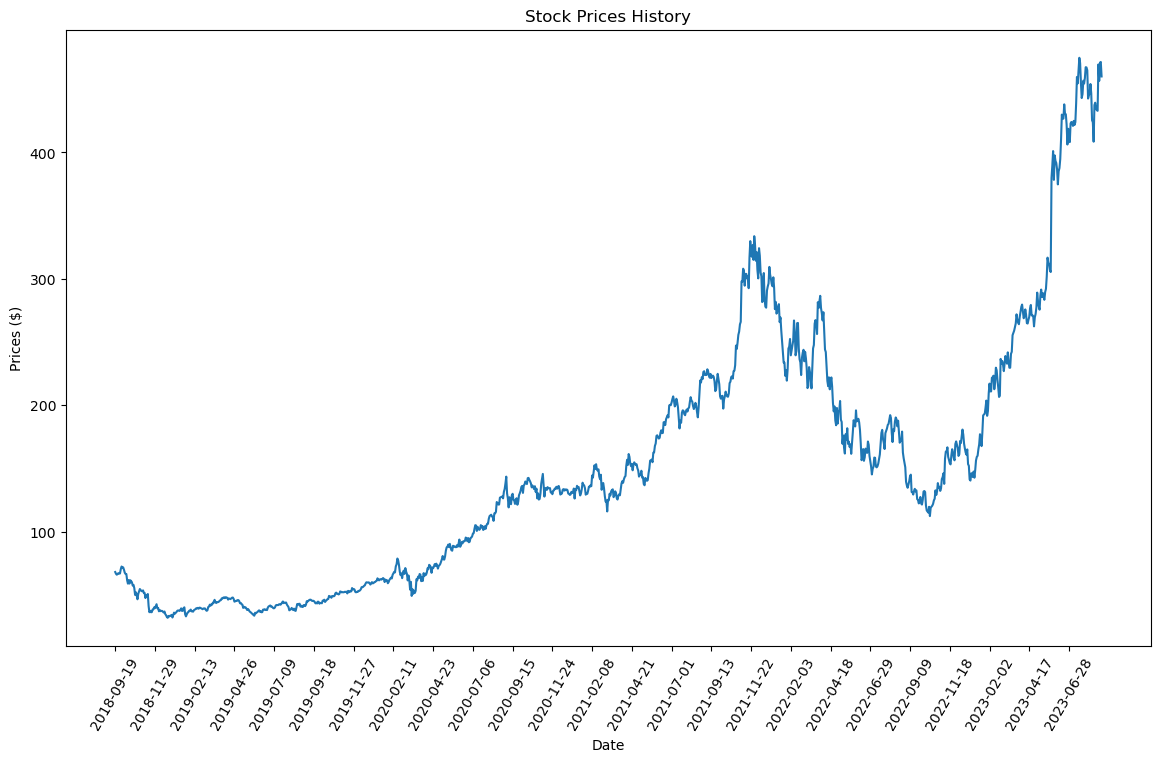

In [16]:
x = hist_price_['date']
plt.figure(figsize=(14, 8))
plt.title('Stock Prices History')
plt.plot(x, hist_price_['close'])
#plt.plot(x, hist_price_['EMAF'])
plt.xticks(x[::50],  rotation='60')
plt.xlabel('Date')
plt.ylabel('Prices ($)')

## Preparing the data for the LSTM Neural Network

### Removing Date column

In [17]:
data_set = hist_price_.iloc[:, 0:13]
pd.set_option('display.max_columns', None)
data_set.drop('date', axis = 1, inplace = True)
data_set.head(5)

,open,high,low,close,adjClose,volume,RSI4,RSI7,RSI10,RSI15,EMA10,EMA15
0,67.5681,68.1748,67.0625,67.9950,67.410896,22485860,44.938544,45.106414,45.424132,45.870546,68.396793,68.677646
1,66.7625,67.1900,66.0250,66.5700,65.998116,43058276,26.200869,33.149607,35.870778,37.980060,68.064649,68.414190
2,66.6900,67.1500,65.5275,65.8625,65.296715,43512628,20.533209,28.737163,32.141656,34.796048,67.664258,68.095229
3,65.5500,66.4600,64.6700,66.4250,65.854378,29391304,35.356588,36.568704,37.849402,39.142103,67.438939,67.886450
4,67.0925,67.3550,66.2275,67.1025,66.526054,28038984,50.257548,45.053777,44.137588,43.962165,67.377768,67.788456


### Using sklearn MinMaxScaler to normalize the data. Converting all values to their coresponding value that is in range between 0 and 1. LSTM can be less efficient when working with large numbers

In [18]:
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data_set)
print(data_set_scaled)

[[0.07639264 0.07588783 0.08161076 ... 0.37944569 0.08168171 0.08151973]
 [0.07468055 0.07379324 0.07925535 ... 0.26387905 0.08090085 0.08089241]
 [0.07452647 0.07370817 0.07812589 ... 0.21724498 0.07995954 0.08013293]
 ...
 [0.90755253 0.93478885 0.95570691 ... 0.58816867 0.97731274 0.98262582]
 [1.         1.         1.         ... 0.59006982 0.98683255 0.98992143]
 [0.93190766 0.94765667 0.9515296  ... 0.52096626 0.98972718 0.99289713]]


### Prepare the training set

In [19]:
X = []

backcandles = 5
print(data_set_scaled.shape[0])
for j in range(12):
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-backcandles:i,j])
        
X  = np.moveaxis(X, [0], [2])

X, yi = np.array(X), np.array(data_set_scaled[backcandles:, -1])
y = np.reshape(yi,(len(yi),1))

print(X.shape)
print(y.shape)

1242
(1237, 5, 12)
(1237, 1)


### Divide the data into train and test using 80:20 ratio

In [20]:
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]

989


In [21]:
model = keras.Sequential()

### Setup the LSTM Neural Network

In [22]:
lstm_input = Input(shape=(backcandles, 12), name = 'lstm_input')
inputs = LSTM(128, name = 'first_layer')(lstm_input)
inputs = Dense(1, name = 'dense_layer')(inputs)
output = Activation('linear', name = 'output')(inputs)
model = Model(inputs = lstm_input, outputs = output)
adam = optimizers.Adam()
model.compile(optimizer = adam, loss = 'mse')

### Train LSTM Model

In [23]:
model.fit(x = X_train, y = y_train, batch_size = 32, epochs = 400, shuffle = True, validation_split = 0.2)

Epoch 1/400
25/25 [==============================] - 3s 28ms/step - loss: 0.0146 - val_loss: 0.0028
Epoch 2/400
25/25 [==============================] - 0s 7ms/step - loss: 5.9589e-04 - val_loss: 1.9469e-04
Epoch 3/400
25/25 [==============================] - 0s 7ms/step - loss: 9.5950e-05 - val_loss: 1.6321e-04
Epoch 4/400
25/25 [==============================] - 0s 7ms/step - loss: 5.8287e-05 - val_loss: 2.3552e-04
Epoch 5/400
25/25 [==============================] - 0s 6ms/step - loss: 3.7443e-05 - val_loss: 1.3799e-04
Epoch 6/400
25/25 [==============================] - 0s 7ms/step - loss: 2.9183e-05 - val_loss: 1.3590e-04
Epoch 7/400
25/25 [==============================] - 0s 7ms/step - loss: 2.3515e-05 - val_loss: 9.9707e-05
Epoch 8/400
25/25 [==============================] - 0s 7ms/step - loss: 1.7907e-05 - val_loss: 1.2106e-04
Epoch 9/400
25/25 [==============================] - 0s 7ms/step - loss: 1.4490e-05 - val_loss: 1.1170e-04
Epoch 10/400
25/25 [========================

25/25 [==============================] - 0s 7ms/step - loss: 2.9360e-06 - val_loss: 2.7451e-05
Epoch 78/400
25/25 [==============================] - 0s 7ms/step - loss: 3.2784e-06 - val_loss: 3.4408e-05
Epoch 79/400
25/25 [==============================] - 0s 7ms/step - loss: 2.9854e-06 - val_loss: 2.5302e-05
Epoch 80/400
25/25 [==============================] - 0s 7ms/step - loss: 2.6386e-06 - val_loss: 3.4156e-05
Epoch 81/400
25/25 [==============================] - 0s 7ms/step - loss: 2.6520e-06 - val_loss: 2.4921e-05
Epoch 82/400
25/25 [==============================] - 0s 7ms/step - loss: 2.7038e-06 - val_loss: 2.5405e-05
Epoch 83/400
25/25 [==============================] - 0s 7ms/step - loss: 2.7500e-06 - val_loss: 2.5541e-05
Epoch 84/400
25/25 [==============================] - 0s 6ms/step - loss: 4.2381e-06 - val_loss: 2.5862e-05
Epoch 85/400
25/25 [==============================] - 0s 6ms/step - loss: 3.7472e-06 - val_loss: 2.3918e-05
Epoch 86/400
25/25 [=====================

25/25 [==============================] - 0s 7ms/step - loss: 6.9707e-06 - val_loss: 1.9595e-05
Epoch 153/400
25/25 [==============================] - 0s 7ms/step - loss: 2.9805e-06 - val_loss: 1.9816e-05
Epoch 154/400
25/25 [==============================] - 0s 6ms/step - loss: 4.9849e-06 - val_loss: 3.6154e-05
Epoch 155/400
25/25 [==============================] - 0s 7ms/step - loss: 9.2969e-06 - val_loss: 4.4113e-05
Epoch 156/400
25/25 [==============================] - 0s 7ms/step - loss: 6.5305e-06 - val_loss: 2.4075e-05
Epoch 157/400
25/25 [==============================] - 0s 7ms/step - loss: 6.5883e-06 - val_loss: 2.2694e-05
Epoch 158/400
25/25 [==============================] - 0s 6ms/step - loss: 3.2970e-06 - val_loss: 1.9773e-05
Epoch 159/400
25/25 [==============================] - 0s 7ms/step - loss: 6.6040e-06 - val_loss: 5.6294e-05
Epoch 160/400
25/25 [==============================] - 0s 7ms/step - loss: 5.0220e-06 - val_loss: 2.3987e-05
Epoch 161/400
25/25 [============

25/25 [==============================] - 0s 7ms/step - loss: 6.1570e-06 - val_loss: 2.0599e-05
Epoch 228/400
25/25 [==============================] - 0s 7ms/step - loss: 4.8700e-06 - val_loss: 1.9433e-05
Epoch 229/400
25/25 [==============================] - 0s 7ms/step - loss: 6.6432e-06 - val_loss: 5.7209e-05
Epoch 230/400
25/25 [==============================] - 0s 6ms/step - loss: 5.1953e-06 - val_loss: 1.6990e-05
Epoch 231/400
25/25 [==============================] - 0s 6ms/step - loss: 2.4855e-06 - val_loss: 1.8487e-05
Epoch 232/400
25/25 [==============================] - 0s 6ms/step - loss: 3.5362e-06 - val_loss: 2.0538e-05
Epoch 233/400
25/25 [==============================] - 0s 6ms/step - loss: 3.6303e-06 - val_loss: 3.9595e-05
Epoch 234/400
25/25 [==============================] - 0s 7ms/step - loss: 2.3943e-06 - val_loss: 1.5739e-05
Epoch 235/400
25/25 [==============================] - 0s 6ms/step - loss: 6.0674e-06 - val_loss: 4.6507e-05
Epoch 236/400
25/25 [============

25/25 [==============================] - 0s 6ms/step - loss: 2.8226e-06 - val_loss: 1.5841e-05
Epoch 303/400
25/25 [==============================] - 0s 7ms/step - loss: 1.7808e-06 - val_loss: 2.6343e-05
Epoch 304/400
25/25 [==============================] - 0s 7ms/step - loss: 2.7246e-06 - val_loss: 5.6163e-05
Epoch 305/400
25/25 [==============================] - 0s 7ms/step - loss: 3.5405e-06 - val_loss: 3.4462e-05
Epoch 306/400
25/25 [==============================] - 0s 7ms/step - loss: 3.7024e-06 - val_loss: 1.9345e-05
Epoch 307/400
25/25 [==============================] - 0s 7ms/step - loss: 1.8326e-06 - val_loss: 1.6512e-05
Epoch 308/400
25/25 [==============================] - 0s 7ms/step - loss: 2.7210e-06 - val_loss: 1.5473e-05
Epoch 309/400
25/25 [==============================] - 0s 7ms/step - loss: 4.4631e-06 - val_loss: 1.3175e-05
Epoch 310/400
25/25 [==============================] - 0s 7ms/step - loss: 1.0947e-05 - val_loss: 6.2769e-05
Epoch 311/400
25/25 [============

25/25 [==============================] - 0s 7ms/step - loss: 1.9230e-06 - val_loss: 1.7270e-05
Epoch 378/400
25/25 [==============================] - 0s 7ms/step - loss: 7.1271e-06 - val_loss: 1.5252e-05
Epoch 379/400
25/25 [==============================] - 0s 7ms/step - loss: 3.0255e-06 - val_loss: 1.9204e-05
Epoch 380/400
25/25 [==============================] - 0s 7ms/step - loss: 3.2184e-06 - val_loss: 1.5041e-05
Epoch 381/400
25/25 [==============================] - 0s 7ms/step - loss: 4.2474e-06 - val_loss: 1.5223e-05
Epoch 382/400
25/25 [==============================] - 0s 8ms/step - loss: 4.7021e-06 - val_loss: 1.5437e-05
Epoch 383/400
25/25 [==============================] - 0s 7ms/step - loss: 3.0316e-06 - val_loss: 1.4632e-05
Epoch 384/400
25/25 [==============================] - 0s 7ms/step - loss: 2.2025e-06 - val_loss: 2.4588e-05
Epoch 385/400
25/25 [==============================] - 0s 7ms/step - loss: 2.8596e-06 - val_loss: 1.3621e-05
Epoch 386/400
25/25 [============

## Model Evaluation

In [25]:
# y_pred = model.predict(X_test)
# for i in range(10):
#     print(y_pred[i], y_test[i])

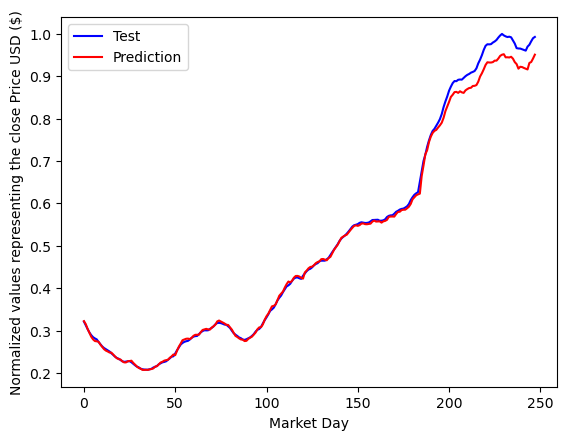

In [26]:
plt.plot(y_test, color = 'blue', label = 'Test')
plt.plot(y_pred, color = 'red', label = 'Prediction')
plt.xlabel('Market Day')
plt.ylabel('Normalized values representing the close Price USD ($)')
plt.legend()
plt.show()